# **Modelling Session Load Prediction**

In this notebook, we train and compare several machine learning models to predict physical load variables from training session tasks.  
We use Random Forest and XGBoost, both with baseline settings and with light hyperparameter tuning.  
⚠️ Since this is a synthetic and fictitious project, hyperparameter tuning has been performed in a lightweight way to save processing time.


## Random Forest (Baseline)

We start with a baseline Random Forest model using default hyperparameters.  
This model serves as a reference to evaluate whether tuning or alternative algorithms can improve predictive performance.


In [3]:
# modelling_rf_baseline_safe_mape.py

# --- 0) Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 1) Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 2) Safe MAPE function (not taking into account 0 values) ---
def mean_absolute_percentage_error_safe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return np.nan  # Si todos son ceros, no se puede calcular
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# --- 3) Load dataset ---
csv_path = "/content/drive/MyDrive/PORTFOLIO/Proyectos/App_Predicción_Cargas_Sesion/synthetic_full_dataset.csv"
df = pd.read_csv(csv_path)

# --- 4) Define inputs and targets ---
categorical_features = ["TaskType", "Team"]

numerical_features = [
    "Length (m)", "Width (m)", "Duration (min)", "Players_Team1", "Players_Team2",
    "Jokers", "Goalkeepers", "Total_Players", "Density (m2/player)"
]

physical_targets = [
    "Distance - Distance (m)",
    "Distance - Abs HSR (m)",
    "Distance - HSR Rel (m/min)",
    "Distance - Abs HSR (% of distance)",
    "Distance - HIA",
    "Distance - HIBD (m)",
    "Accelerations - High Intensity Acc Abs (count)",
    "Accelerations - High Intensity Acc Abs (m)",
    "Accelerations - High Intensity Dec Abs (count)",
    "Accelerations - High Intensity Dec Abs (m)",
    "Accelerations - Max Acceleration (m/s²)",
    "Accelerations - Max Deceleration (m/s²)",
    "Speed Zones (m) [0.0, 6.0]",
    "Speed Zones (m) [6.0, 12.0]",
    "Speed Zones (m) [12.0, 18.0]",
    "Speed Zones (m) [18.0, 21.0]",
    "Speed Zones (m) [21.0, 24.0]",
    "Speed Zones (m) [24.0, 50.0]"
]

# --- 5) Loop over each target variable ---
rf_results = {}

for target in physical_targets:
    print(f"\n=== RF BASELINE TARGET: {target} ===\n")

    X = df[categorical_features + numerical_features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

    # --- RF Baseline ---
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error_safe(y_test, y_pred)

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("MAPE (safe):", mape)

    # Saving results for a manual revision
    rf_results[target] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Predictions": y_pred
    }




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== RF BASELINE TARGET: Distance - Distance (m) ===

MAE: 114.71319928536916
RMSE: 293.1647797661524
R2: 0.948878289248401
MAPE (safe): 12.844439483028836

=== RF BASELINE TARGET: Distance - Abs HSR (m) ===

MAE: 77.04884169466946
RMSE: 247.213717382029
R2: 0.9385722271415751
MAPE (safe): 13.398039220169588

=== RF BASELINE TARGET: Distance - HSR Rel (m/min) ===

MAE: 3.318073818827532
RMSE: 5.956947437649971
R2: 0.9500875349926071
MAPE (safe): 12.171739537877995

=== RF BASELINE TARGET: Distance - Abs HSR (% of distance) ===

MAE: 5.094095690750378
RMSE: 7.225433381041603
R2: 0.9019445214945842
MAPE (safe): 12.10658111347462

=== RF BASELINE TARGET: Distance - HIA ===

MAE: 0.6975511297447371
RMSE: 1.1240305777255386
R2: 0.9434990718693772
MAPE (safe): 12.37435969772129

=== RF BASELINE TARGET: Distance - HIBD (m) ===

MAE: 0.5563367337544334
RMSE: 0.890358

## XGBoost (Baseline)

Next, we test a baseline XGBoost model using default hyperparameters.  
XGBoost often outperforms Random Forest on tabular data, especially when relationships between features and targets are non-linear.


In [4]:
# modelling_xgb_baseline_safe_mape.py

# --- 0) Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 1) Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 2) Safe MAPE function ---
def mean_absolute_percentage_error_safe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return np.nan  # Si todos son ceros
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# --- 3) Load dataset ---
csv_path = "/content/drive/MyDrive/PORTFOLIO/Proyectos/App_Predicción_Cargas_Sesion/synthetic_full_dataset.csv"
df = pd.read_csv(csv_path)

# --- 4) Define inputs and targets ---
categorical_features = ["TaskType", "Team"]

numerical_features = [
    "Length (m)", "Width (m)", "Duration (min)", "Players_Team1", "Players_Team2",
    "Jokers", "Goalkeepers", "Total_Players", "Density (m2/player)"
]

physical_targets = [
    "Distance - Distance (m)",
    "Distance - Abs HSR (m)",
    "Distance - HSR Rel (m/min)",
    "Distance - Abs HSR (% of distance)",
    "Distance - HIA",
    "Distance - HIBD (m)",
    "Accelerations - High Intensity Acc Abs (count)",
    "Accelerations - High Intensity Acc Abs (m)",
    "Accelerations - High Intensity Dec Abs (count)",
    "Accelerations - High Intensity Dec Abs (m)",
    "Accelerations - Max Acceleration (m/s²)",
    "Accelerations - Max Deceleration (m/s²)",
    "Speed Zones (m) [0.0, 6.0]",
    "Speed Zones (m) [6.0, 12.0]",
    "Speed Zones (m) [12.0, 18.0]",
    "Speed Zones (m) [18.0, 21.0]",
    "Speed Zones (m) [21.0, 24.0]",
    "Speed Zones (m) [24.0, 50.0]"
]

# --- 5) Loop over each target variable ---
xgb_results = {}

for target in physical_targets:
    print(f"\n=== XGBOOST BASELINE TARGET: {target} ===\n")

    X = df[categorical_features + numerical_features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

    # --- XGBoost Baseline ---
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ])

    xgb_pipeline.fit(X_train, y_train)
    y_pred = xgb_pipeline.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error_safe(y_test, y_pred)

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("MAPE (safe):", mape)

    # Save results for inspection
    xgb_results[target] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Predictions": y_pred
    }



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== XGBOOST BASELINE TARGET: Distance - Distance (m) ===

MAE: 123.08322369659416
RMSE: 309.97147252924543
R2: 0.9428488144376119
MAPE (safe): 15.07427181207793

=== XGBOOST BASELINE TARGET: Distance - Abs HSR (m) ===

MAE: 86.85166028612178
RMSE: 260.38630949463555
R2: 0.9318515579336657
MAPE (safe): 33.89483078065755

=== XGBOOST BASELINE TARGET: Distance - HSR Rel (m/min) ===

MAE: 3.5500732390201004
RMSE: 6.021490989416937
R2: 0.9490000718458468
MAPE (safe): 18.357987008956513

=== XGBOOST BASELINE TARGET: Distance - Abs HSR (% of distance) ===

MAE: 5.287038386304961
RMSE: 7.3313636588163655
R2: 0.899048311826409
MAPE (safe): 13.860147021140046

=== XGBOOST BASELINE TARGET: Distance - HIA ===

MAE: 0.8290547843955963
RMSE: 1.1909534280103695
R2: 0.9365708505157114
MAPE (safe): 17.888983404737967

=== XGBOOST BASELINE TARGET: Distance - HIBD (m) ===

MAE

## Random Forest (Light Tuning)

Here we apply a light hyperparameter search with RandomizedSearchCV.  
The search space and number of iterations are intentionally small to reduce runtime.  
This tuned version should improve accuracy over the baseline, but results are constrained by the lightweight tuning setup.


In [5]:
# modelling_rf_tuned_fast_safe_mape.py

# --- 0) Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 1) Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# --- 2) Safe MAPE function ---
def mean_absolute_percentage_error_safe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return np.nan
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# --- 3) Load dataset ---
csv_path = "/content/drive/MyDrive/PORTFOLIO/Proyectos/App_Predicción_Cargas_Sesion/synthetic_full_dataset.csv"
df = pd.read_csv(csv_path)

# --- 4) Define inputs and targets ---
categorical_features = ["TaskType", "Team"]

numerical_features = [
    "Length (m)", "Width (m)", "Duration (min)", "Players_Team1", "Players_Team2",
    "Jokers", "Goalkeepers", "Total_Players", "Density (m2/player)",
]

physical_targets = [
    "Distance - Distance (m)",
    "Distance - Abs HSR (m)",
    "Distance - HSR Rel (m/min)",
    "Distance - Abs HSR (% of distance)",
    "Distance - HIA",
    "Distance - HIBD (m)",
    "Accelerations - High Intensity Acc Abs (count)",
    "Accelerations - High Intensity Acc Abs (m)",
    "Accelerations - High Intensity Dec Abs (count)",
    "Accelerations - High Intensity Dec Abs (m)",
    "Accelerations - Max Acceleration (m/s²)",
    "Accelerations - Max Deceleration (m/s²)",
    "Speed Zones (m) [0.0, 6.0]",
    "Speed Zones (m) [6.0, 12.0]",
    "Speed Zones (m) [12.0, 18.0]",
    "Speed Zones (m) [18.0, 21.0]",
    "Speed Zones (m) [21.0, 24.0]",
    "Speed Zones (m) [24.0, 50.0]"
]

# --- 5) Loop over each target variable ---
rf_tuned_results = {}

for target in physical_targets:
    print(f"\n=== RANDOM FOREST TUNED (FAST) TARGET: {target} ===\n")

    X = df[categorical_features + numerical_features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

    # RF Pipeline
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    # Hyperparameter search reduced
    rf_param_dist = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }

    rf_random = RandomizedSearchCV(
        rf_pipeline, rf_param_dist, n_iter=5, cv=3,
        scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )

    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error_safe(y_test, y_pred)

    print("Best params:", rf_random.best_params_)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("MAPE (safe):", mape)

    # Saving model and results
    rf_tuned_results[target] = {
        "BestParams": rf_random.best_params_,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Predictions": y_pred,
        "Model": rf_random.best_estimator_
    }



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== RANDOM FOREST TUNED (FAST) TARGET: Distance - Distance (m) ===

Best params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 10}
MAE: 122.02250851136874
RMSE: 287.04827223638415
R2: 0.95098921423178
MAPE (safe): 15.486411007474493

=== RANDOM FOREST TUNED (FAST) TARGET: Distance - Abs HSR (m) ===

Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
MAE: 76.0197028697338
RMSE: 241.73565094093553
R2: 0.9412644488637616
MAPE (safe): 13.515594079418669

=== RANDOM FOREST TUNED (FAST) TARGET: Distance - HSR Rel (m/min) ===

Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
MAE: 3.303874486362055
RMSE: 5.904850753624465
R2: 0.9509567397502613
MAPE (s

## XGBoost (Light Tuning)

We then run a light hyperparameter tuning for XGBoost using RandomizedSearchCV.  
Again, the search space and number of iterations are limited due to the synthetic nature of the project.  
The tuned version aims to improve predictive accuracy compared to the baseline.


In [6]:
# modelling_xgb_tuned_fast_safe_mape.py

# --- 0) Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 1) Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# --- 2) Safe MAPE function ---
def mean_absolute_percentage_error_safe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return np.nan
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# --- 3) Load dataset ---
csv_path = "/content/drive/MyDrive/PORTFOLIO/Proyectos/App_Predicción_Cargas_Sesion/synthetic_full_dataset.csv"
df = pd.read_csv(csv_path)

# --- 4) Define inputs and targets ---
categorical_features = ["TaskType", "Team"]

numerical_features = [
    "Length (m)", "Width (m)", "Duration (min)", "Players_Team1", "Players_Team2",
    "Jokers", "Goalkeepers", "Total_Players", "Density (m2/player)"
]

physical_targets = [
    "Distance - Distance (m)",
    "Distance - Abs HSR (m)",
    "Distance - HSR Rel (m/min)",
    "Distance - Abs HSR (% of distance)",
    "Distance - HIA",
    "Distance - HIBD (m)",
    "Accelerations - High Intensity Acc Abs (count)",
    "Accelerations - High Intensity Acc Abs (m)",
    "Accelerations - High Intensity Dec Abs (count)",
    "Accelerations - High Intensity Dec Abs (m)",
    "Accelerations - Max Acceleration (m/s²)",
    "Accelerations - Max Deceleration (m/s²)",
    "Speed Zones (m) [0.0, 6.0]",
    "Speed Zones (m) [6.0, 12.0]",
    "Speed Zones (m) [12.0, 18.0]",
    "Speed Zones (m) [18.0, 21.0]",
    "Speed Zones (m) [21.0, 24.0]",
    "Speed Zones (m) [24.0, 50.0]"
]

# --- 5) Loop over each target variable ---
xgb_tuned_results = {}

for target in physical_targets:
    print(f"\n=== XGBOOST TUNED (FAST) TARGET: {target} ===\n")

    X = df[categorical_features + numerical_features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

    # XGB Pipeline
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ))
    ])

    # Hyperparameter search reduced
    xgb_param_dist = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, 10],
        'model__learning_rate': [0.05, 0.1, 0.3],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }

    xgb_random = RandomizedSearchCV(
        xgb_pipeline, xgb_param_dist, n_iter=5, cv=3,
        scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )

    xgb_random.fit(X_train, y_train)
    y_pred = xgb_random.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error_safe(y_test, y_pred)

    print("Best params:", xgb_random.best_params_)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("MAPE (safe):", mape)

    # Save results and model
    xgb_tuned_results[target] = {
        "BestParams": xgb_random.best_params_,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Predictions": y_pred,
        "Model": xgb_random.best_estimator_
    }


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== XGBOOST TUNED (FAST) TARGET: Distance - Distance (m) ===

Best params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
MAE: 130.54857945767435
RMSE: 285.90038793859736
R2: 0.9513804113207249
MAPE (safe): 18.015303618670693

=== XGBOOST TUNED (FAST) TARGET: Distance - Abs HSR (m) ===

Best params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
MAE: 99.06423174891809
RMSE: 247.02133292586956
R2: 0.9386677974881401
MAPE (safe): 40.15828580468321

=== XGBOOST TUNED (FAST) TARGET: Distance - HSR Rel (m/min) ===

Best params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 6, 'model__learning_rate': 0.3, 'model__colsample_bytree': 0.8}
MAE: 3.802411488691

## Model Comparison

Finally, we compare the four models across all physical load targets.  
We report standard regression metrics (MAE, RMSE, R², MAPE).  
The best model for each target is selected based on RMSE, although MAE, R², and MAPE are also displayed for complementary insights.


In [7]:
import pandas as pd

# --- 1) Initialize comparison ---
all_models = {
    "RF Baseline": rf_results,
    "XGB Baseline": xgb_results,
    "RF Tuned Fast": rf_tuned_results,
    "XGB Tuned Fast": xgb_tuned_results
}

comparison_rows = []

# --- 2) Loop over targets ---
for target in physical_targets:
    target_metrics = []

    for model_name, results in all_models.items():
        metrics = results[target]
        target_metrics.append({
            "Target": target,
            "Model": model_name,
            "MAE": metrics["MAE"],
            "RMSE": metrics["RMSE"],
            "R2": metrics["R2"],
            "MAPE": metrics["MAPE"]
        })

    # Convert to DataFrame
    df_tmp = pd.DataFrame(target_metrics)

    # --- Winner selection ---
    # By RMSE
    best_rmse_idx = df_tmp["RMSE"].idxmin()
    df_tmp.loc[best_rmse_idx, "Best_RMSE"] = True

    # By MAE
    best_mae_idx = df_tmp["MAE"].idxmin()
    df_tmp.loc[best_mae_idx, "Best_MAE"] = True

    # By R²
    best_r2_idx = df_tmp["R2"].idxmax()
    df_tmp.loc[best_r2_idx, "Best_R2"] = True

    # By MAPE
    best_mape_idx = df_tmp["MAPE"].idxmin()
    df_tmp.loc[best_mape_idx, "Best_MAPE"] = True

    comparison_rows.append(df_tmp)

# --- 3) Concatenate all results ---
comparison_df = pd.concat(comparison_rows, ignore_index=True)

# --- 4) Pretty display ---
pd.set_option("display.max_rows", None)
print(comparison_df)

# --- 5) Best per target (mainly RMSE) ---
best_per_target = comparison_df[comparison_df["Best_RMSE"] == True][
    ["Target", "Model", "RMSE", "MAPE", "R2"]
]
print("\n=== BEST MODELS PER TARGET (by RMSE) ===\n")
print(best_per_target)


                                            Target           Model  \
0                          Distance - Distance (m)     RF Baseline   
1                          Distance - Distance (m)    XGB Baseline   
2                          Distance - Distance (m)   RF Tuned Fast   
3                          Distance - Distance (m)  XGB Tuned Fast   
4                           Distance - Abs HSR (m)     RF Baseline   
5                           Distance - Abs HSR (m)    XGB Baseline   
6                           Distance - Abs HSR (m)   RF Tuned Fast   
7                           Distance - Abs HSR (m)  XGB Tuned Fast   
8                       Distance - HSR Rel (m/min)     RF Baseline   
9                       Distance - HSR Rel (m/min)    XGB Baseline   
10                      Distance - HSR Rel (m/min)   RF Tuned Fast   
11                      Distance - HSR Rel (m/min)  XGB Tuned Fast   
12              Distance - Abs HSR (% of distance)     RF Baseline   
13              Dist

### Why RMSE was selected as the primary metric, leading tuned RF as best model

Among the evaluated metrics, RMSE (Root Mean Squared Error) was chosen as the main criterion to select the final model.  
The reason is that RMSE penalizes larger errors more strongly than MAE or MAPE, which is particularly important in this context:  
underestimating or overestimating session load by a large margin could lead to misleading conclusions for training planning.  
Additionally, RMSE preserves the units of the original variables (e.g., meters, accelerations), making the magnitude of the error directly interpretable.  
While R² and MAPE provide complementary insights, RMSE ensures that the selected model achieves the most reliable balance between accuracy and robustness.




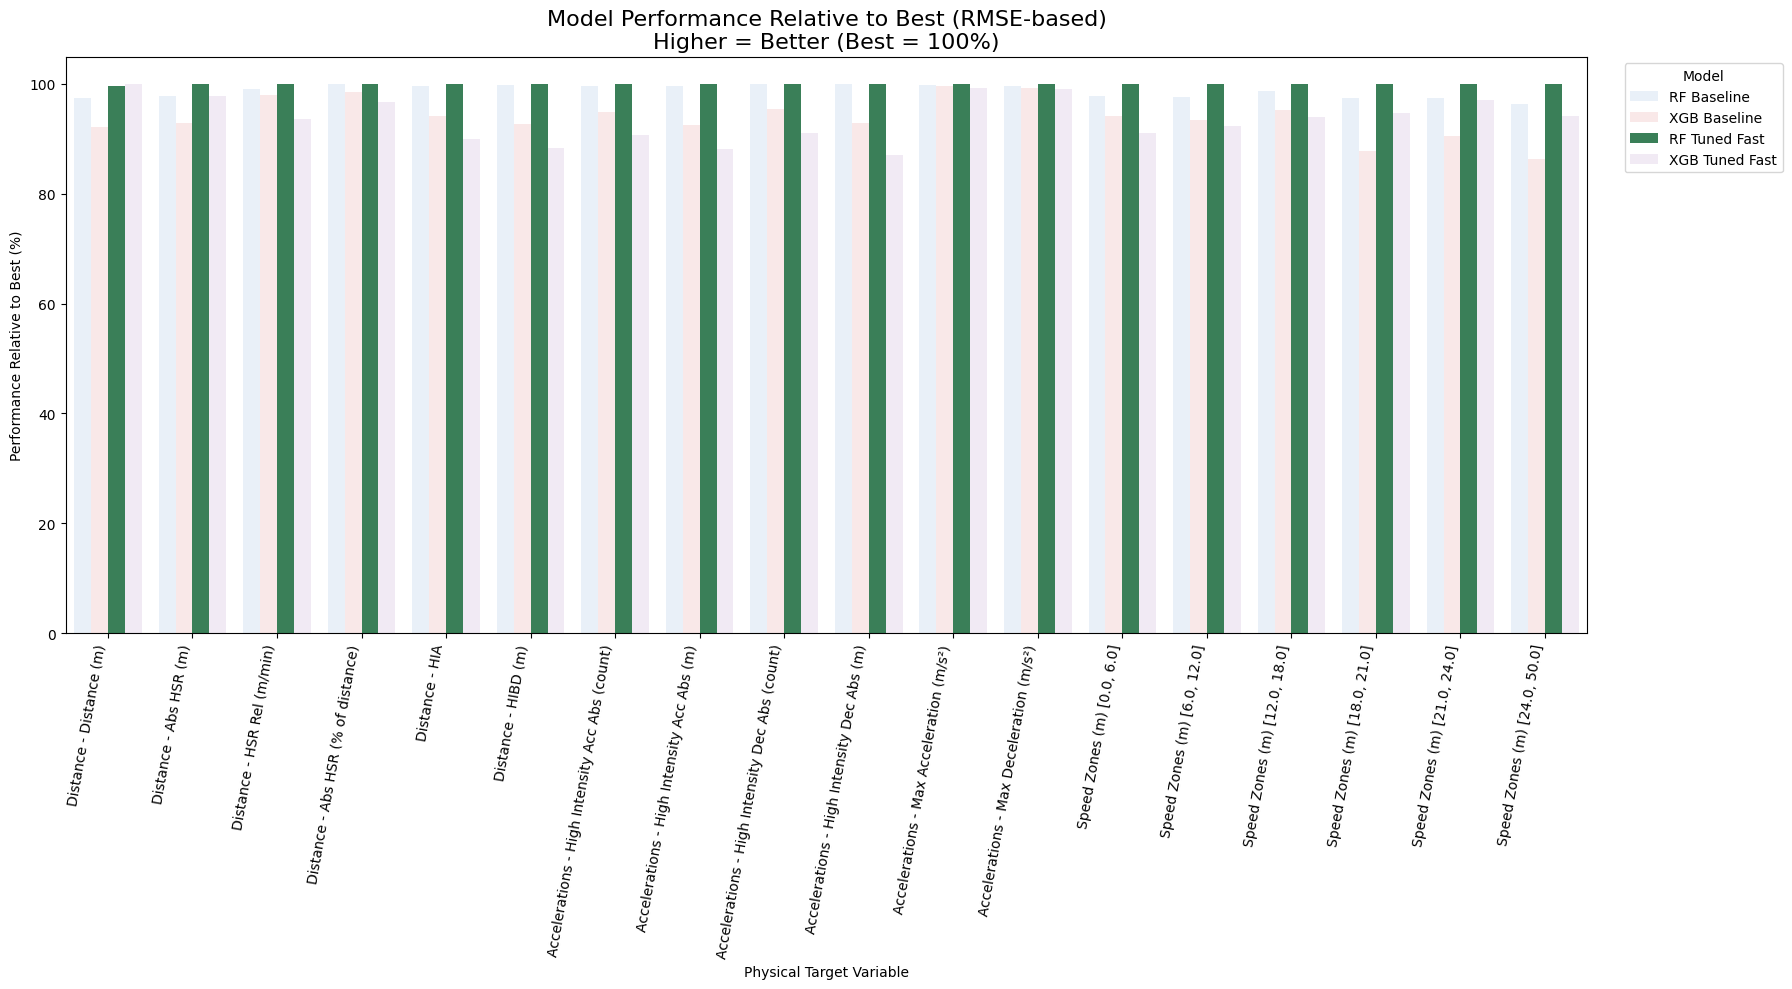

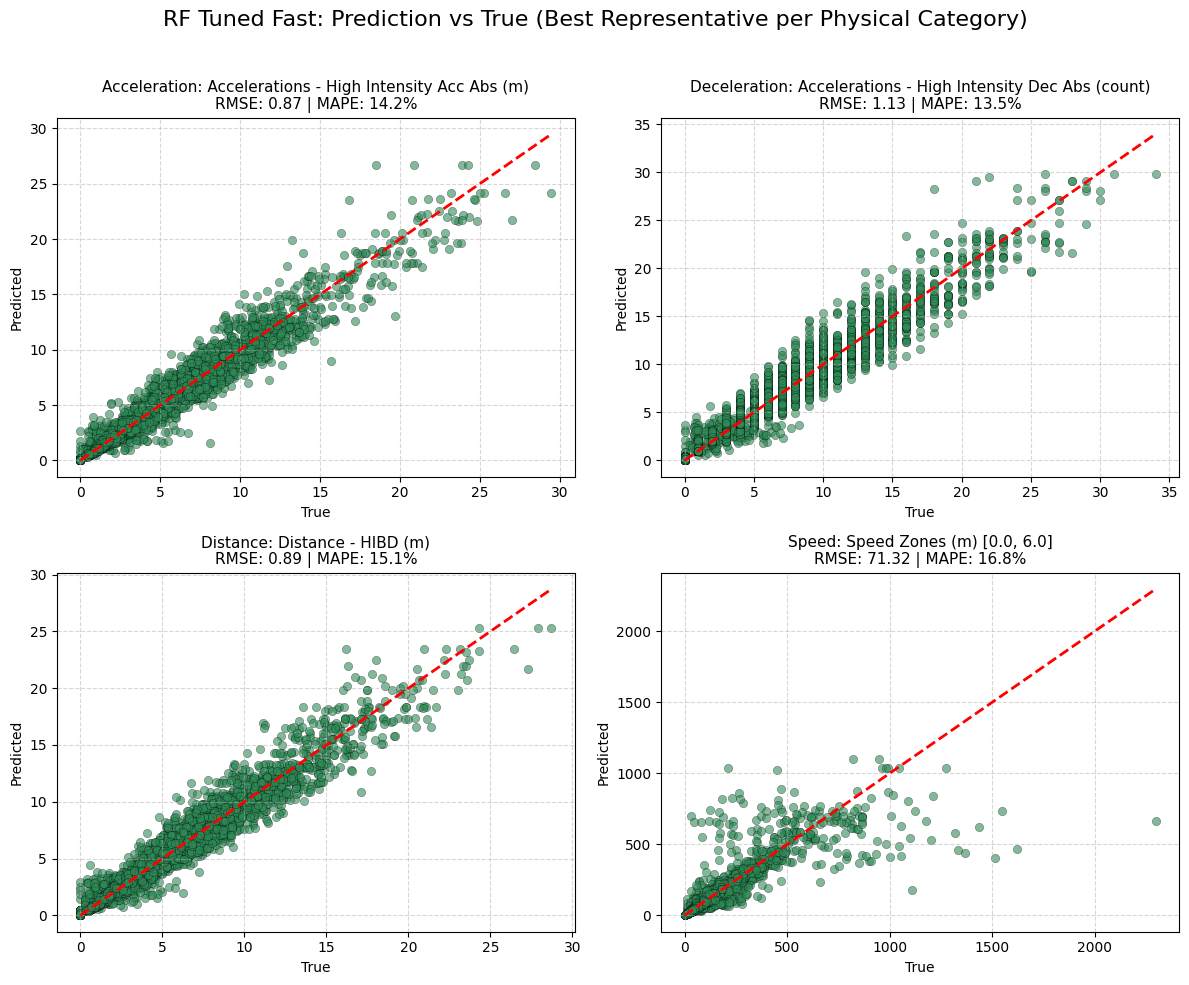

/tmp/ipython-input-1369044294.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wins.index, y=wins.values, ax=axes[idx], palette=colors_viz)
/tmp/ipython-input-1369044294.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wins.index, y=wins.values, ax=axes[idx], palette=colors_viz)
/tmp/ipython-input-1369044294.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wins.index, y=wins.values, ax=axes[idx], palette=colors_viz)
/tmp/ipython-input-1369044294.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

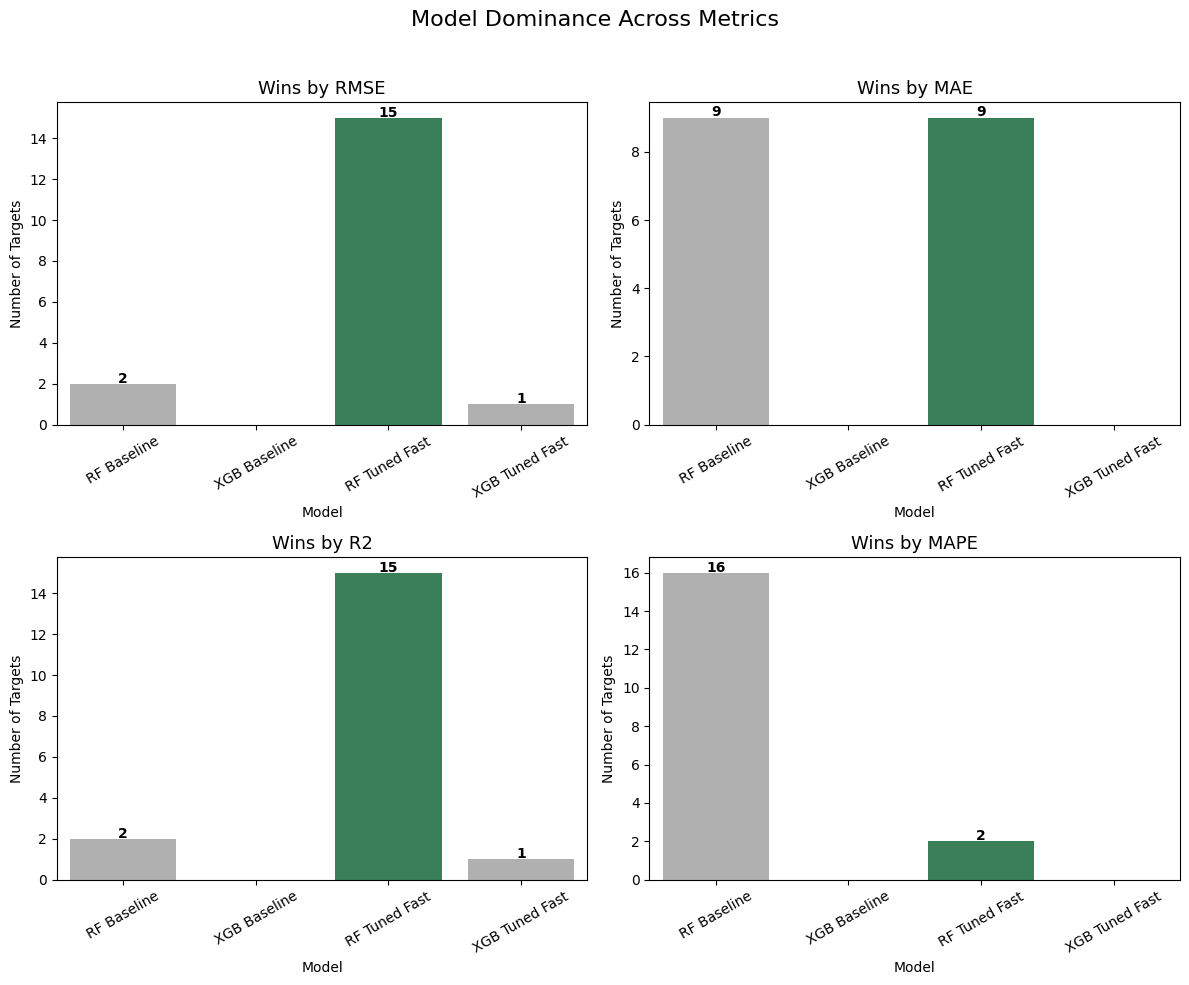

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Secure booleanos
comparison_df = comparison_df.fillna(False)

# --- 1) Relative performance (inverse by RMSE), destacando RF Tuned Fast ---
df_plot = comparison_df.copy()
df_plot['Performance_Relative'] = df_plot.groupby('Target')['RMSE'].transform(lambda x: (x.min() / x) * 100)

model_colors = {
    "RF Tuned Fast": "#2E8B57",
    "RF Baseline":    "#E6F0FA",
    "XGB Baseline":   "#FCE5E5",
    "XGB Tuned Fast": "#F2E9F5"
}

plt.figure(figsize=(18, 10))
sns.barplot(data=df_plot, x="Target", y="Performance_Relative", hue="Model", palette=model_colors, dodge=True)
plt.title("Model Performance Relative to Best (RMSE-based)\nHigher = Better (Best = 100%)", fontsize=16)
plt.xlabel("Physical Target Variable")
plt.ylabel("Performance Relative to Best (%)")
plt.xticks(rotation=80, ha='right')
plt.ylim(0, 105)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 2) Prediction vs Real → ONE PER CATEGORY ---
# Only targets where RF Tuned Fast had the best RMSE
rf_tuned_wins_df = comparison_df[
    (comparison_df["Model"] == "RF Tuned Fast") & (comparison_df["Best_RMSE"] == True)
].copy()

category_keywords = {
    "Distance": ["Distance -"],
    "Acceleration": ["Acc "],
    "Deceleration": ["Dec "],
    "Speed": ["Speed Zones"]
}

# Map each target to a category
def assign_category(target):
    for cat, keywords in category_keywords.items():
        if any(kw in target for kw in keywords):
            return cat
    return "Other"

rf_tuned_wins_df["Category"] = rf_tuned_wins_df["Target"].apply(assign_category)

# Filter only categories of interest
categories_of_interest = ["Distance", "Acceleration", "Deceleration", "Speed"]
rf_tuned_wins_df = rf_tuned_wins_df[rf_tuned_wins_df["Category"].isin(categories_of_interest)]

# Select the lowest RMSE per category
best_per_category = rf_tuned_wins_df.loc[
    rf_tuned_wins_df.groupby("Category")["RMSE"].idxmin()
]

selected_targets = best_per_category["Target"].tolist()
categories_selected = best_per_category["Category"].tolist()

if selected_targets:
    n_targets = len(selected_targets)
    n_cols = 2
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for idx, (target, cat) in enumerate(zip(selected_targets, categories_selected)):
        ax = axes[idx]

        X = df[categorical_features + numerical_features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        y_pred = rf_tuned_results[target]["Predictions"]

        ax.scatter(y_test, y_pred, alpha=0.6, color='#2E8B57', edgecolor='k', linewidth=0.3)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        rmse_val = rf_tuned_results[target]["RMSE"]
        mape_val = rf_tuned_results[target]["MAPE"]
        ax.set_title(f"{cat}: {target}\nRMSE: {rmse_val:.2f} | MAPE: {mape_val:.1f}%", fontsize=11)
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True, linestyle='--', alpha=0.5)


    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("RF Tuned Fast: Prediction vs True (Best Representative per Physical Category)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No representative targets found where 'RF Tuned Fast' won by RMSE in key categories.")

# --- 3) Victories per metric (2x2) ---
metrics_info = {
    "RMSE": "Best_RMSE",
    "MAE": "Best_MAE",
    "R2": "Best_R2",
    "MAPE": "Best_MAPE"
}

model_order = ["RF Baseline", "XGB Baseline", "RF Tuned Fast", "XGB Tuned Fast"]
colors_viz = ['#B0B0B0', '#B0B0B0', '#2E8B57', '#B0B0B0']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (metric, best_col) in enumerate(metrics_info.items()):
    wins = comparison_df[comparison_df[best_col] == True]["Model"].value_counts().reindex(model_order, fill_value=0)

    sns.barplot(x=wins.index, y=wins.values, ax=axes[idx], palette=colors_viz)
    axes[idx].set_title(f"Wins by {metric}", fontsize=13)
    axes[idx].set_xlabel("Model")
    axes[idx].set_ylabel("Number of Targets")
    axes[idx].tick_params(axis='x', rotation=30)

    for i, v in enumerate(wins.values):
        if v > 0:
            axes[idx].text(i, v + 0.05, str(v), ha='center', fontweight='bold')

plt.suptitle("Model Dominance Across Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [25]:
# Extract R² values for all targets in RF Tuned Fast
r2_values = [metrics["R2"] for metrics in rf_tuned_results.values()]

# Count how many above R² > 0.90
r2_above_90 = sum(1 for r2 in r2_values if r2 > 0.90)

# Percentage
total_targets = len(r2_values)
percentage_r2_above_90 = (r2_above_90 / total_targets) * 100

# Show results
print(f"Total evaluated targets: {total_targets}")
print(f"Targets with R² > 90%: {r2_above_90}")
print(f"Percentage: {percentage_r2_above_90:.1f}%")

Total evaluated targets: 18
Targets with R² > 90%: 10
Percentage: 55.6%


In [26]:
# For 80%...
r2_values = [metrics["R2"] for metrics in rf_tuned_results.values()]


r2_above_80 = sum(1 for r2 in r2_values if r2 > 0.80)


total_targets = len(r2_values)
percentage_r2_above_80 = (r2_above_80 / total_targets) * 100


print(f"Total evaluated targets: {total_targets}")
print(f"Targets with R² > 80%: {r2_above_80}")
print(f"Percentage: {percentage_r2_above_80:.1f}%")

Total evaluated targets: 18
Targets with R² > 80%: 12
Percentage: 66.7%
